# Machine Learning Analysis

Here we work with the processed data in the file `df_fire_10_11_off.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from datetime import date, timedelta
from scipy.stats import binom
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA

import json
from pandas.io.json import json_normalize

plt.rcParams.update({'errorbar.capsize': 2})

We will be working with `KMeans` clustering. An interesting approach in determining the ideal number of clusters was presented in:

R. Tibshirani, G. Walther, and T. Hastie, “Estimating the number of clusters in a data set via the gap statistic,” Journal of the Royal Statistical Society: Series B (Statistical Methodology) 63 No. 2, 411–423,

https://rss.onlinelibrary.wiley.com/doi/pdf/10.1111/1467-9868.00293

The idea is to compute a gap statistic and to compare it with the one obtained from the average of random normally-distributed arrays of identical shape and ranges. To do so, we shall use the following function which produces those random arrays, fits `KMeans` with $k$ clusters to them and computes the $\log$ of their inertias:

In [2]:
def log_inertias_random_mu_sigma(data,k,B):
    """Creates B random sets with the size of data with range [0,1], fits KMeans with k clusters to them and computes
    the log of their inertias. Produces the mean and standard deviation of these logs as output."""

    log_inertias_rand = []


    for i in range(B):
            
        # Random set, fit and inertias
        random_set = np.random.random_sample(size=data.shape)
            
        model_random = KMeans(n_clusters=k, random_state=10)
        model_random.fit(random_set)
            
        log_inertias_rand.append(np.log(model_random.inertia_))
    
    mu = np.mean(log_inertias_rand)
    sigma = np.std(log_inertias_rand)
    
    return mu, sigma

Let us first perform some additional data wrangling.

## Some Additional Data Wrangling

We start by importing the csv file `df_fire_10_11_off.csv`. We also remove the call type `'Automatic Fire Alarm False'`, as it is likely irrelevant for our purposes.

In [3]:
df_fire_10_11_off = pd.read_csv('processed_data/df_fire_10_11_off.csv', parse_dates = ['Datetime'])

df_fire_10_11_off = df_fire_10_11_off[df_fire_10_11_off.Type != 'Automatic Fire Alarm False']

df_fire_10_11_off.head()

,Type,Datetime,Latitude,Longitude,C_gauge,Off_Day
0,Auto Fire Alarm,2010-12-07,47.608434,-122.338125,RG11,0
1,Car Fire,2010-12-05,47.655047,-122.381130,RG12,1
2,Auto Fire Alarm,2010-11-26,47.621113,-122.358044,RG11,1
3,Auto Fire Alarm,2010-11-25,47.607266,-122.332451,RG20_25,1
5,Auto Fire Alarm,2011-03-01,47.602114,-122.330809,RG20_25,0


We have to deal with the categorical feature `'Type'`. We have 28 distinct possible values in this feature:

In [4]:
df_fire_10_11_off['Type'].describe()

count                4807
unique                 28
top       Auto Fire Alarm
freq                 3062
Name: Type, dtype: object

In order to cluster this dataset, we will use instead numbers for these values and store the identification in a dataframe called `df_type`. We will store this information as a `csv` in the `processed_data` folder:

In [5]:
Type_Unique = sorted(df_fire_10_11_off['Type'].unique())

Type_Unique_Dict = {Type_Unique[i] : i for i in range(len(Type_Unique))}

df_type = pd.DataFrame({'Type':Type_Unique})

df_type

,Type
0,Auto Fire Alarm
1,Automatic Fire Alarm Resd
2,Automatic Fire Dist 11
3,Bark Fire
4,Boat Fire In Marina
5,Boat Under 50' Fire Shore
6,Boat Under 50' Fire Water
7,Brush Fire
8,Brush Fire W/Exp.
9,Car Fire


In [6]:
#df_type.to_csv('df_type.csv', encoding='utf-8', index=False)

We use this identification in the `Type` column and remove the `Datetime` and `C_gauge` columns. While these contain information, we choose to remove them from further analysis. From the date information, we are keeping only the column `Off_Day`. A deeper analysis of `Datetime` is surely interesting in itself, but we leave this to future work. `C_gauge`, on the other hand, is direclty a function of the location, so it is correlated data.

In [7]:
df0 = df_fire_10_11_off.replace({'Type': Type_Unique_Dict}).drop(columns=['C_gauge','Datetime'])

In [8]:
df0.head()

,Type,Latitude,Longitude,Off_Day
0,0,47.608434,-122.338125,0
1,9,47.655047,-122.381130,1
2,0,47.621113,-122.358044,1
3,0,47.607266,-122.332451,1
5,0,47.602114,-122.330809,0


Finally, we use `get_dummies` to turn the categorical column `Type` into several binary data columns, one for each category. In doing this, we drop one of the columns, which is linearly dependent with the rest. We also save this dataframe `df` as `df.csv` in the `processed_data` folder.

In [9]:
df = pd.get_dummies(df0,columns=['Type'],prefix = '', prefix_sep='',drop_first=True)

In [10]:
df.head()

,Latitude,Longitude,Off_Day,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,47.608434,-122.338125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47.655047,-122.381130,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,47.621113,-122.358044,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47.607266,-122.332451,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,47.602114,-122.330809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#df.to_csv('df.csv', encoding='utf-8', index=False)

## Clustering

We will explore different approaches to the clustering of this data set. These are:

a) Clustering only `'Longitude'` and `'Latitude`' of the emergency calls. We do this with `MinMaxScaler` and `KMeans` with distinct number of clusters $k$. We compute the most common parameters to decide the ideal $k$, such as inertia, silhouette, gap statistic and the gap criterium of Tibshirani, Walther and Hastie (2000) we mentioned.

b) We then tackle the whole data set with a `PCA` dimensional reduction. By computing variance we try to establish the ideal dimension. This can be done with and without previously scaling with `StandardScaler`. We find that in this case the model responds better without previous scaling.

Looking at the behavior of the cumulative explained variance, one sees that 2D PCA represents accurately about 69% of the data, and the elbow rule would suggest that the ideal dimension is likely 3, representing about 76% of the data. We perform clustering with `MinMaxScaler` and `KMeans` of the projected 2D and 3D data, using the same parameters we mentioned in a) to establish the ideal $k$.

c) Finally, we also experiment with clustering all data without using PCA. Here we do this with `MinMaxScaler` and `KMeans`, testing, as before, different possible $k$'s.

### Clustering Location only

We start with a clustering of only the location of the 911 emergency calls, which is registered in the columns `'Longitude'` and `'Latitude`'. Fisrt we pick store this location data in an array and scale it with `MinMaxScaler`. This sets the range of data to [0,1]:

In [12]:
#Notice that in the following array X0 we pick a column order
#consistent with our plotting x,y convention which may or may
#not match alphabetical order:
X0 = df[['Longitude','Latitude']].values

scaler = MinMaxScaler()

X = scaler.fit_transform(X0)

We follow with the application of `KMeans`. As we will do repeatedly, we use a series of parameters to determine which number of clusters is ideal. This includes inertia, average and individual silhouettes, gap and the gap criterium.

1) Inertia corresponds to the sum of squared distances of samples to their closest cluster center and can be computed with the attribute `inertia_`.

2) `silhouette_samples` takes into account both the distance of each point to points in its own cluster and to points in others to give a measure of how solid the structure found in a model really is. `silhouette_score` computes an average over all points.

3) The gap statistic $\mathrm{Gap}(k)$ compares the inertia of the model and the inertia of models built from random arrays of identical size and range. Ideally, high values of this parameter are preferred. In addition, we use the criterium which suggests that the ideal $k$ is the lowest one that satisfies
\begin{equation}
\mathrm{Gap}(k) \geq \mathrm{Gap}(k+1) - s_{k+1} \, ,
\end{equation}
where $s_k$ is a (weighted) standard deviation of the random sample clusterings.

Here we compute these parameters considering a range of possible values of $k$ that we store in `Ks`. In `B`, we pick the number of random samples that we use in the computation of $\mathrm{Gap}(k)$. We store all these parameters in `inertias`, `gaps`, `silhouettes`, `s_k` and `gap_criterium`.

In [13]:
B = 3
Ks = list(range(1,11))

inertias = []
gaps = []
stds_log_inertias_random = []
silhouettes = []

for k in Ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(X)
    
    #Computing and storing inertia
    inertia = model.inertia_
    inertias.append(inertia)
    
    #Computing and storing gap and np.std(np.log(inertias_random)), using inertias_rand(X,k)
    mu , sigma = log_inertias_random_mu_sigma(X,k,B)
    gap = mu - np.log(inertia)
    gaps.append(gap)
    stds_log_inertias_random.append(sigma)
    
    model_labels = model.fit_predict(X)
    
    #Computing and storing average silhouettes
    if k > 1:
        silhouette_avg = silhouette_score(X, model_labels)
        silhouettes.append(silhouette_avg)
    
# We have used B random sets in inertias_rand(X,k), which leads to
s_k = np.sqrt(1+1/B) * np.array(stds_log_inertias_random)

gap_criterium = []

for k in Ks[:-1]:
    
    #gaps and s_k start at k = min(Ks), hence we add correction to the expression
    gap_criterium.append(gaps[(k-min(Ks))] - gaps[(k-min(Ks))+1] + s_k[(k-min(Ks))+1])

Now we can plot all these parameters:

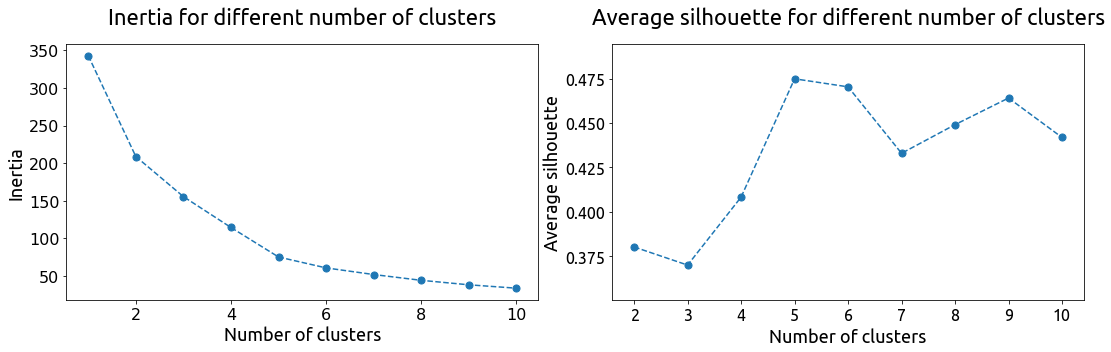

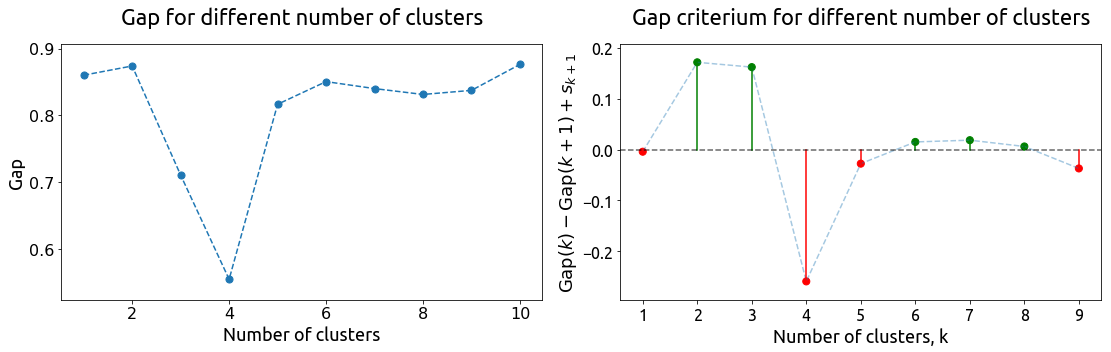

In [15]:
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].scatter(Ks,inertias, s = 50)
ax[0].plot(Ks,inertias, linestyle='--')
ax[0].set_ylabel('Inertia', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Inertia for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

ax[1].scatter(list(set(Ks)-set([1])),silhouettes, s = 50)
ax[1].plot(list(set(Ks)-set([1])),silhouettes, linestyle='--')
ax[1].set_ylabel('Average silhouette', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Average silhouette for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("loc_parfigs_1.pdf", bbox_inches='tight')
fig.tight_layout()


fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].scatter(Ks,gaps, s = 50)
ax[0].plot(Ks,gaps, linestyle='--')
ax[0].set_ylabel('Gap', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Gap for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')


col_scatt = lambda y : 'red' if y < 0 else 'green'
cols = [ col_scatt(i) for i in gap_criterium ]

ax[1].scatter(Ks[:-1],gap_criterium, c = cols, s = 50)
ax[1].plot(Ks[:-1],gap_criterium, linestyle='--', alpha=0.4)
markerline, stemlines, baseline = ax[1].stem(Ks[:-1],gap_criterium, markerfmt=' ')
plt.setp(baseline, linewidth=0)
for i,j in enumerate(stemlines):
    plt.setp(j, c = cols[i], linestyle='-')
    
ax[1].axhline(0, linestyle='--', color='black', alpha = 0.6)
ax[1].set_ylabel('$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters, k', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Gap criterium for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("loc_parfigs_2.pdf", bbox_inches='tight')
fig.tight_layout()

The elbow rule in the inertias plot seems to suggest the values $k =5,6$. These also have high average silhouettes, together with $k=9$, although all values are below 0.5. $k = 1, 2, 6, 10$ have high $\mathrm{Gap}(k)$, but when we take a look of the gap criterium, we see that $k=2$ is the lowest number of clusters that have a positive score. It should also be noticed that $k= 3, 6, 7$ also have a positive gap-criterium-score. All factors being taken together, we decide to pick $k=6$ in this study, in the spirit of following fundamentally the silhouette and $\mathrm{Gap}(k)$ score. 

We can also made silhouette plots to get a graphical representation of individual scores. For simplicity, we make plots only for $k=2,5,6$ and store the labels produced in the $k=6$ clustering.

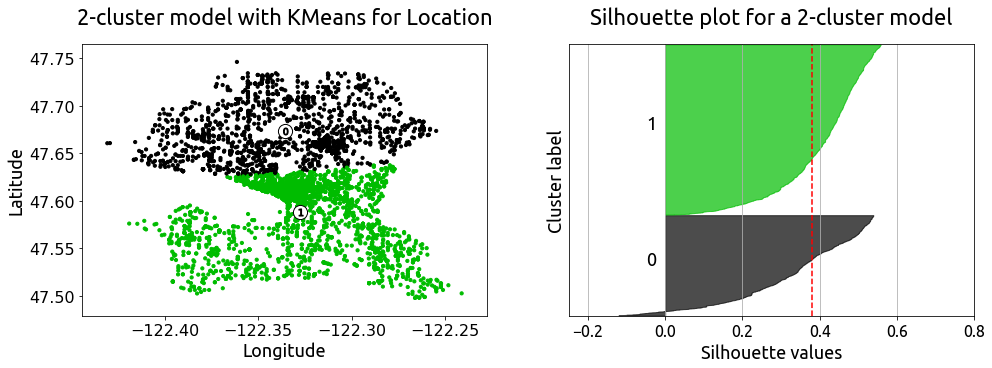

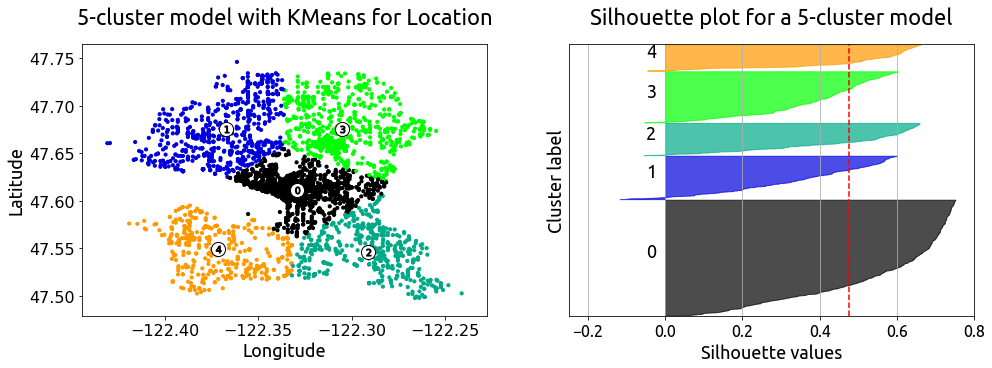

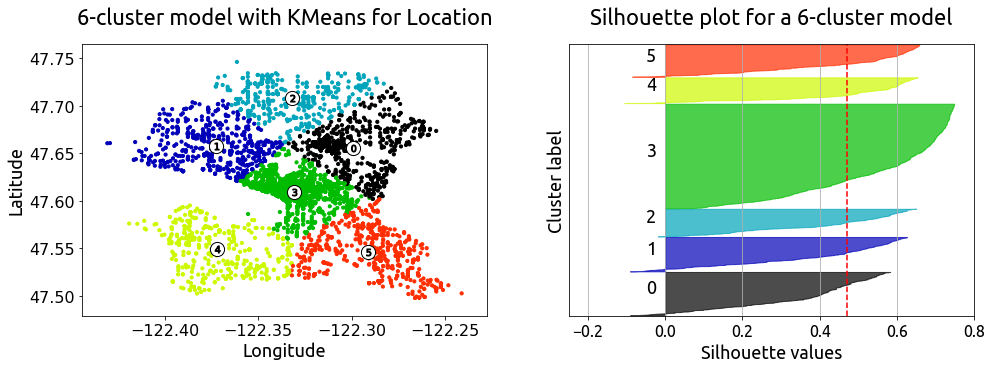

In [17]:
chosen_k = 6

for k in [2,5,6]:

    fig, ax = plt.subplots(ncols=2,figsize=(16,5))
    
    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    model = KMeans(n_clusters=k, random_state=10)
    model_labels = model.fit_predict(X)
    
    if k == chosen_k:
        chosen_k_labels = model_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, model_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, model_labels)
    
    # Labeling the clusters
    centers0 = model.cluster_centers_
    
    ################################
    centers = scaler.inverse_transform(centers0)
    
    
    colors = cm.nipy_spectral(model_labels.astype(float) / k)

    ax[0].scatter(X0[:,0],X0[:,1],c=colors,alpha=1, s=10)
    ax[0].set_title(str(k)+"-cluster model with KMeans for Location", fontsize=22, fontname='Ubuntu', pad= 20)
    ax[0].set_xlabel("Longitude", fontsize=18, fontname='Ubuntu')
    ax[0].set_ylabel("Latitude", fontsize=18, fontname='Ubuntu')
    
    
    # Draw white circles at cluster centers
    ax[0].scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax[0].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax[0].tick_params(labelsize=16)
    ax[0].grid(False)
    plt.xticks(fontname='Ubuntu')
    plt.yticks(fontname='Ubuntu')
    
    
    #########################################
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within
    ax[1].set_xlim([-0.25, 0.8])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax[1].set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax[1].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=18, fontname='Ubuntu')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[1].set_title("Silhouette plot for a "+str(k)+"-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
    ax[1].set_xlabel("Silhouette values", fontsize=18, fontname='Ubuntu')
    ax[1].set_ylabel("Cluster label", fontsize=18, fontname='Ubuntu')

    # The vertical line for average silhouette score of all the values
    ax[1].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[1].set_yticks([])  # Clear the yaxis labels / tick
    #ax.set_xticks(list(np.linspace(-0.25, 0.65, num=7)))
    ax[1].xaxis.grid(True)
    ax[1].tick_params(labelsize=16)
    plt.xticks(fontname='Ubuntu')
    
    #fig.savefig("loc_clusfigs_"+str(k)+"_cluster.pdf", bbox_inches='tight')

We store the labels in `location_data_chosen_k_labels.npy`, which can be found in the `processed_data` folder.

In [36]:
#np.save('location_data_chosen_k_labels.npy', chosen_k_labels)

### PCA Dimensional Reduction

Now we can proceed to perform dimensional reduction via PCA.

#### PCA with Scaling

First, let us consider the case of scaled data via `StandardScaler`.

In [18]:
X0 = df.values.astype(float)

scaler = StandardScaler()

X = scaler.fit_transform(X0)

We fit use PCA and fit to the data.

In [19]:
pca = PCA()

pca.fit(X)

features = range(1,pca.n_components_+1)

In order to see the effectiveness of PCA, we study the cumulative explained variance as a fucntion of the number of dimensions:

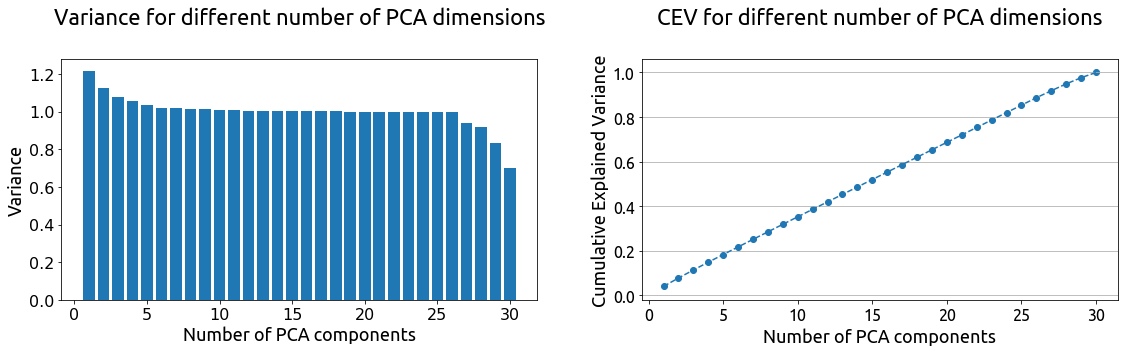

In [21]:
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].bar(features, pca.explained_variance_)
ax[0].set_ylabel('Variance', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of PCA components', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Variance for different number of PCA dimensions", fontsize=22, fontname='Ubuntu', pad= 35)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')


ax[1].scatter(features,np.cumsum(pca.explained_variance_ratio_))
ax[1].plot(features,np.cumsum(pca.explained_variance_ratio_), linestyle='--')
ax[1].set_ylabel('Cumulative Explained Variance', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of PCA components', fontsize=18, fontname='Ubuntu')
ax[1].set_title("CEV for different number of PCA dimensions", fontsize=22, fontname='Ubuntu', pad= 35)
ax[1].tick_params(labelsize=16)
ax[1].yaxis.grid(True)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("PCA_scaled_variance.pdf", bbox_inches='tight')
fig.tight_layout()

This is not performing ideally. It seems to suggest that only high dimensionality can explain a significant percentage of the data behavior.

#### PCA without Scaling

We consider instead the case of PCA without previously performing scaling. We follow the same steps we used to study explained variance as a function of the number of dimensions:

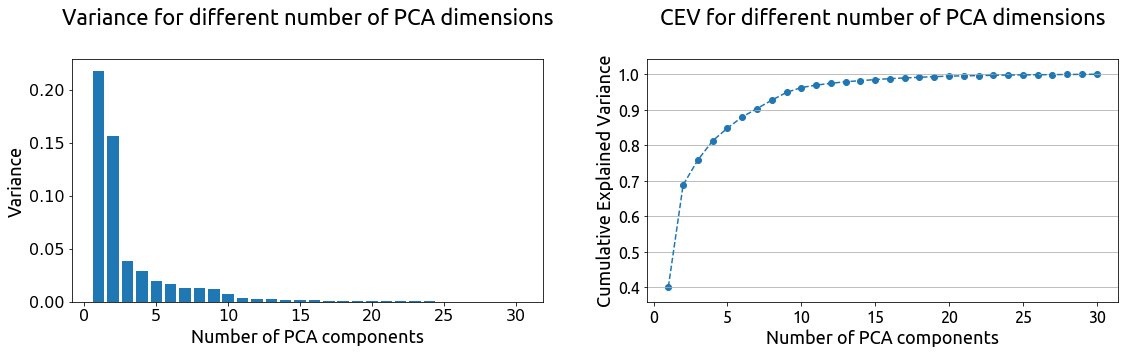

In [22]:
X = df.values.astype(float)

pca = PCA()

pca.fit(X)

features = range(1,pca.n_components_+1)

fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].bar(features, pca.explained_variance_)
ax[0].set_ylabel('Variance', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of PCA components', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Variance for different number of PCA dimensions", fontsize=22, fontname='Ubuntu', pad= 35)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')


ax[1].scatter(features,np.cumsum(pca.explained_variance_ratio_))
ax[1].plot(features,np.cumsum(pca.explained_variance_ratio_), linestyle='--')
ax[1].set_ylabel('Cumulative Explained Variance', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of PCA components', fontsize=18, fontname='Ubuntu')
ax[1].set_title("CEV for different number of PCA dimensions", fontsize=22, fontname='Ubuntu', pad= 35)
ax[1].tick_params(labelsize=16)
ax[1].yaxis.grid(True)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("PCA_not_scaled_variance.pdf", bbox_inches='tight')
fig.tight_layout()

In [23]:
print(np.cumsum(pca.explained_variance_ratio_)[:4])

[0.40075614 0.68817638 0.75849682 0.81237531]


As we see, with 2 dimensions we can account for about 69% of the data and with 3 we reach almost 76%. The elbow rule indicates that $D=3$ is a good choice for dimensional reduction.

#### PCA without Scaling in 2D

Now we can implement distinc types of clustering on the whole data set. We will pick the 2 most significant PCA components and use them for graphical purposes. More specificaly, we will obtain distinct label sets which we can then project in the 2D PCA subspace to study their performance visually.

In [24]:
pca = PCA(n_components=2)

pca_transformed = pca.fit_transform(df.values.astype(float))

Let us project the data on the 2D subspace:

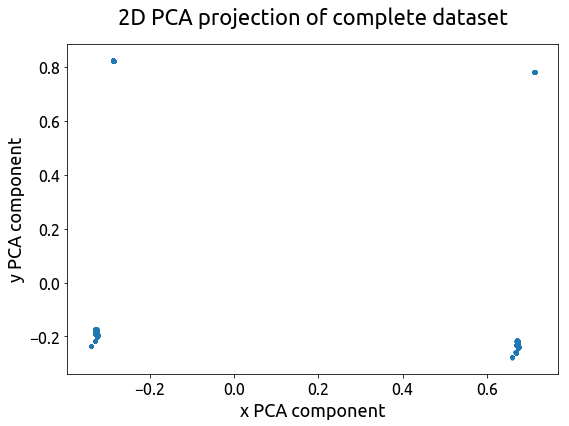

In [25]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(pca_transformed[:,0],pca_transformed[:,1],s=10)
ax.set_ylabel('y PCA component', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('x PCA component', fontsize=18, fontname='Ubuntu')
ax.set_title("2D PCA projection of complete dataset", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("2D_PCA_data.pdf", bbox_inches='tight')
fig.tight_layout()

Interestingly, we have very well delimited clusters after performing this projection. Let us confirm our suspicions by studying a `MinMaxScaler` + `KMeans` clustering on the reduced data. We follow the same steps we used in previous searches to pick the ideal $k$:

In [26]:
X0 = pca_transformed

scaler = MinMaxScaler()

X = scaler.fit_transform(X0)

B = 6
Ks = list(range(1,11))

inertias = []
gaps = []
stds_log_inertias_random = []
silhouettes = []

for k in Ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(X)
    
    #Computing and storing inertia
    inertia = model.inertia_
    inertias.append(inertia)
    
    #Computing and storing gap and np.std(np.log(inertias_random)), using inertias_rand(X,k)
    mu , sigma = log_inertias_random_mu_sigma(X,k,B)
    gap = mu - np.log(inertia)
    gaps.append(gap)
    stds_log_inertias_random.append(sigma)
    
    model_labels = model.fit_predict(X)
    
    #Computing and storing average silhouettes
    if k > 1:
        silhouette_avg = silhouette_score(X, model_labels)
        silhouettes.append(silhouette_avg)
    
# We have used B random sets in inertias_rand(X,k), which leads to
s_k = np.sqrt(1+1/B) * np.array(stds_log_inertias_random)

gap_criterium = []

for k in Ks[:-1]:
    
    #gaps and s_k start at k = min(Ks), hence we add correction to the expression
    gap_criterium.append(gaps[(k-min(Ks))] - gaps[(k-min(Ks))+1] + s_k[(k-min(Ks))+1])

We plot these data as usual:

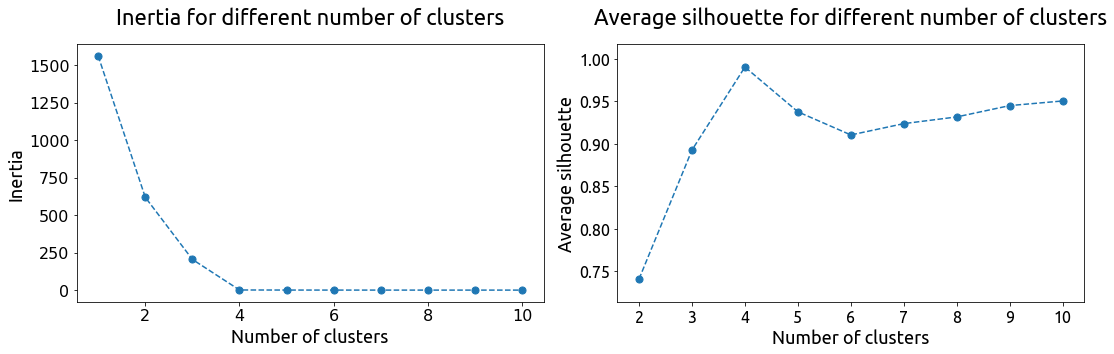

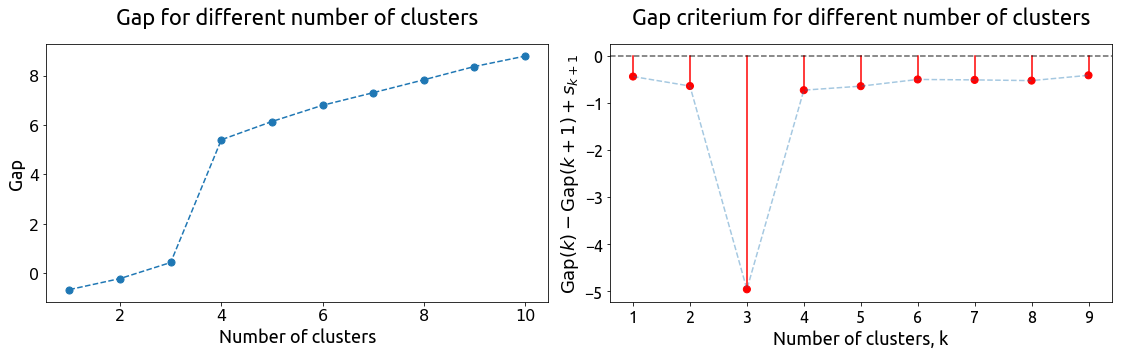

In [27]:
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].scatter(Ks,inertias, s = 50)
ax[0].plot(Ks,inertias, linestyle='--')
ax[0].set_ylabel('Inertia', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Inertia for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

ax[1].scatter(list(set(Ks)-set([1])),silhouettes, s = 50)
ax[1].plot(list(set(Ks)-set([1])),silhouettes, linestyle='--')
ax[1].set_ylabel('Average silhouette', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Average silhouette for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("PCA_2D_parfigs_1.pdf", bbox_inches='tight')
fig.tight_layout()


fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].scatter(Ks,gaps, s = 50)
ax[0].plot(Ks,gaps, linestyle='--')
ax[0].set_ylabel('Gap', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Gap for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')


col_scatt = lambda y : 'red' if y < 0 else 'green'
cols = [ col_scatt(i) for i in gap_criterium ]

ax[1].scatter(Ks[:-1],gap_criterium, c = cols, s = 50)
ax[1].plot(Ks[:-1],gap_criterium, linestyle='--', alpha=0.4)
markerline, stemlines, baseline = ax[1].stem(Ks[:-1],gap_criterium, markerfmt=' ')
plt.setp(baseline, linewidth=0)
for i,j in enumerate(stemlines):
    plt.setp(j, c = cols[i], linestyle='-')
    
ax[1].axhline(0, linestyle='--', color='black', alpha = 0.6)
ax[1].set_ylabel('$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters, k', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Gap criterium for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("PCA_2D_parfigs_2.pdf", bbox_inches='tight')
fig.tight_layout()

The gap criterium seems unreliable in this situation. By comparing with the previous application, we conjecture that one reason behind this behavior could be the radical change in scale for the inertias as $k$ reaches the elbow point, which my translate in undesirable values.

On the other hand, $\mathrm{Gap}(k)$ is monotonically increasing. The average silhouette and the elbow rule both seem to point to the $k=4$ expected result, that we could have predicted from the 2D projected data.

The silhouette and labeled data plots for $k=4$ show the desired clustering.

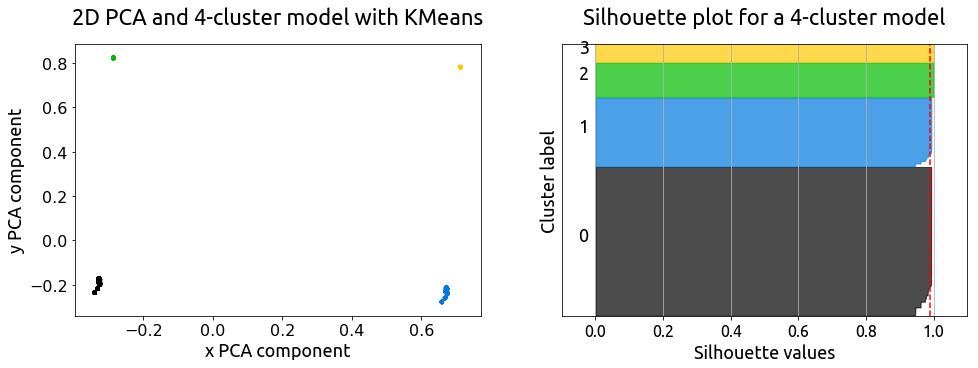

In [28]:
chosen_k = 4

for k in [4]:

    fig, ax = plt.subplots(ncols=2,figsize=(16,5))
    
    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    model = KMeans(n_clusters=k, random_state=10)
    model_labels = model.fit_predict(X)
    
    if k == chosen_k:
        chosen_k_labels = model_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, model_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, model_labels)
    
    # Labeling the clusters
    centers0 = model.cluster_centers_
    
    ################################
    colors = cm.nipy_spectral(model_labels.astype(float) / k)
    
    centers = scaler.inverse_transform(centers0)
      

    ax[0].scatter(pca_transformed[:,0],pca_transformed[:,1],c=colors,alpha=1, s=10)
    ax[0].set_title("2D PCA and "+str(k)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
    ax[0].set_xlabel("x PCA component", fontsize=18, fontname='Ubuntu')
    ax[0].set_ylabel("y PCA component", fontsize=18, fontname='Ubuntu')
    
    
    # Draw white circles at cluster centers
    #ax[0].scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax[0].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    ax[0].tick_params(labelsize=16)
    ax[0].grid(False)
    plt.xticks(fontname='Ubuntu')
    plt.yticks(fontname='Ubuntu')
    
    
    #########################################
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within
    ax[1].set_xlim([-0.1, 1.1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax[1].set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax[1].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=18, fontname='Ubuntu')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[1].set_title("Silhouette plot for a "+str(k)+"-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
    ax[1].set_xlabel("Silhouette values", fontsize=18, fontname='Ubuntu')
    ax[1].set_ylabel("Cluster label", fontsize=18, fontname='Ubuntu')

    # The vertical line for average silhouette score of all the values
    ax[1].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[1].set_yticks([])  # Clear the yaxis labels / tick
    #ax.set_xticks(list(np.linspace(-0.25, 0.65, num=7)))
    ax[1].xaxis.grid(True)
    ax[1].tick_params(labelsize=16)
    plt.xticks(fontname='Ubuntu')
    
    #fig.savefig("PCA_2D_clusfigs_"+str(k)+"_cluster.pdf", bbox_inches='tight')

 We also store the labels as before:

In [32]:
#np.save('2D_pca_complete_data_chosen_k_labels.npy', chosen_k_labels)

#### PCA without Scaling in 3D

Now we proceed to perform PCA reduction to $D=3$.

In [29]:
pca = PCA(n_components=3)

pca_transformed = pca.fit_transform(df.values.astype(float))

The projected data seems well arranged:

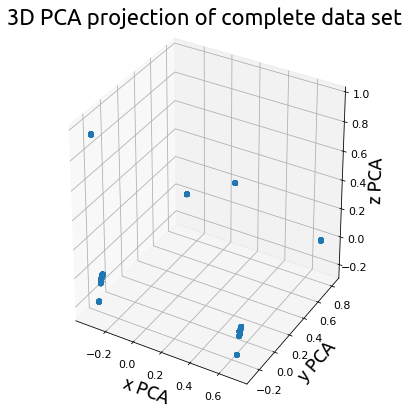

In [30]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_transformed[:,0],pca_transformed[:,1],pca_transformed[:,2], s = 20)
ax.set_title("3D PCA projection of complete data set", fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel('x PCA', fontsize=18, fontname='Ubuntu')
ax.set_ylabel('y PCA', fontsize=18, fontname='Ubuntu')
ax.set_zlabel('z PCA', fontsize=18, fontname='Ubuntu')
ax.tick_params(labelsize=11)

#fig.savefig("PCA_3D_data.pdf", bbox_inches='tight')
fig.tight_layout()

Let us do some clustering on these projected data:

In [31]:
X0 = pca_transformed

scaler = MinMaxScaler()

X = scaler.fit_transform(X0)

B = 6
Ks = list(range(1,11))

inertias = []
gaps = []
stds_log_inertias_random = []
silhouettes = []

for k in Ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(X)
    
    #Computing and storing inertia
    inertia = model.inertia_
    inertias.append(inertia)
    
    #Computing and storing gap and np.std(np.log(inertias_random)), using inertias_rand(X,k)
    mu , sigma = log_inertias_random_mu_sigma(X,k,B)
    gap = mu - np.log(inertia)
    gaps.append(gap)
    stds_log_inertias_random.append(sigma)
    
    model_labels = model.fit_predict(X)
    
    #Computing and storing average silhouettes
    if k > 1:
        silhouette_avg = silhouette_score(X, model_labels)
        silhouettes.append(silhouette_avg)
    
# We have used B random sets in inertias_rand(X,k), which leads to
s_k = np.sqrt(1+1/B) * np.array(stds_log_inertias_random)

gap_criterium = []

for k in Ks[:-1]:
    
    #gaps and s_k start at k = min(Ks), hence we add correction to the expression
    gap_criterium.append(gaps[(k-min(Ks))] - gaps[(k-min(Ks))+1] + s_k[(k-min(Ks))+1])

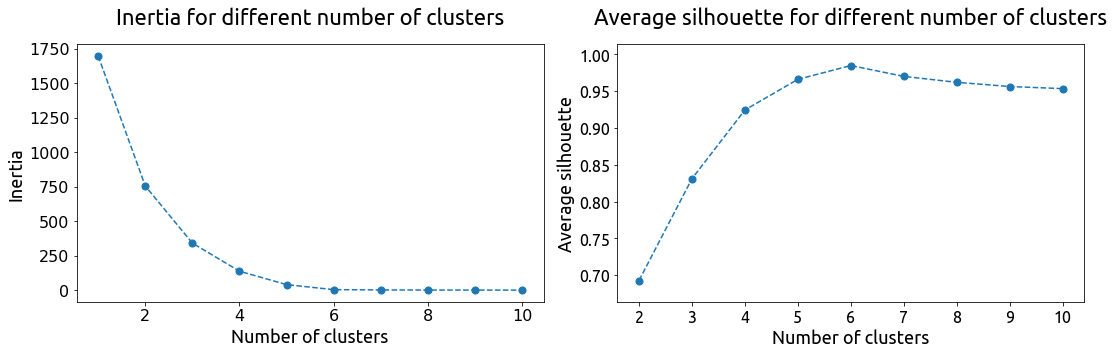

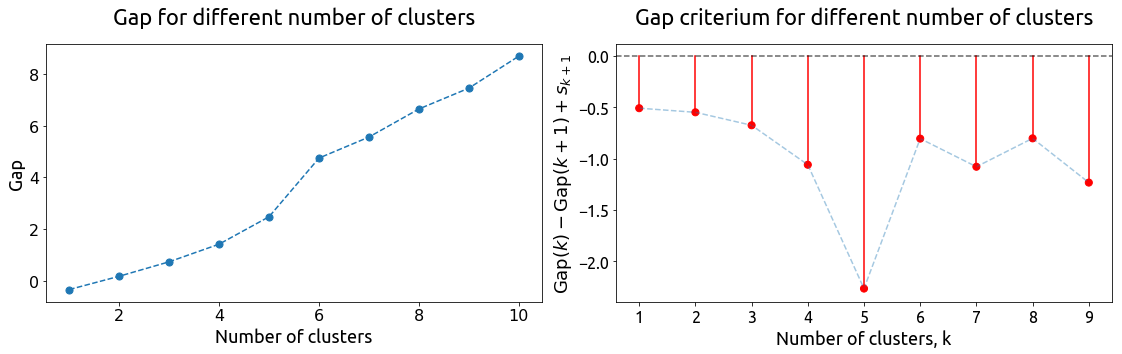

In [32]:
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].scatter(Ks,inertias, s = 50)
ax[0].plot(Ks,inertias, linestyle='--')
ax[0].set_ylabel('Inertia', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Inertia for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

ax[1].scatter(list(set(Ks)-set([1])),silhouettes, s = 50)
ax[1].plot(list(set(Ks)-set([1])),silhouettes, linestyle='--')
ax[1].set_ylabel('Average silhouette', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Average silhouette for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("PCA_3D_parfigs_1.pdf", bbox_inches='tight')
fig.tight_layout()


fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].scatter(Ks,gaps, s = 50)
ax[0].plot(Ks,gaps, linestyle='--')
ax[0].set_ylabel('Gap', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Gap for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')


col_scatt = lambda y : 'red' if y < 0 else 'green'
cols = [ col_scatt(i) for i in gap_criterium ]

ax[1].scatter(Ks[:-1],gap_criterium, c = cols, s = 50)
ax[1].plot(Ks[:-1],gap_criterium, linestyle='--', alpha=0.4)
markerline, stemlines, baseline = ax[1].stem(Ks[:-1],gap_criterium, markerfmt=' ')
plt.setp(baseline, linewidth=0)
for i,j in enumerate(stemlines):
    plt.setp(j, c = cols[i], linestyle='-')
    
ax[1].axhline(0, linestyle='--', color='black', alpha = 0.6)
ax[1].set_ylabel('$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters, k', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Gap criterium for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("PCA_3D_parfigs_2.pdf", bbox_inches='tight')
fig.tight_layout()

In this case, the gap criterium does not seem to be a useful parameter. The $\mathrm{Gap}(k)$ is a monotonically increasing function. $k=6$ seems like a good choice from the point of view of the elbow rule in the inertias plot and the behavior of the silhouette score. This also seems reasonable from the point of view of the projected data scatter plot. Additional plotting verifies this:

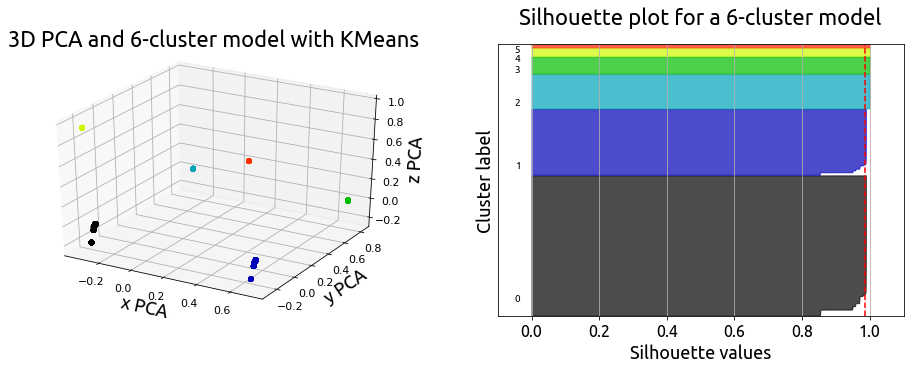

In [33]:
chosen_k = 6

for k in [6]:

    fig = plt.figure(figsize=(16,5))
    
    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    model = KMeans(n_clusters=k, random_state=10)
    model_labels = model.fit_predict(X)
    
    if k == chosen_k:
        chosen_k_labels = model_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, model_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, model_labels)
    
    # Labeling the clusters
    centers0 = model.cluster_centers_
    
    ################################
    colors = cm.nipy_spectral(model_labels.astype(float) / k)
    
    centers = scaler.inverse_transform(centers0)

    ax = fig.add_subplot(1, 2, 1, projection='3d')

    ax.scatter(pca_transformed[:,0],pca_transformed[:,1],pca_transformed[:,2], s = 20,c=colors,alpha=1)
    ax.set_title("3D PCA and "+str(k)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
    ax.set_xlabel('x PCA', fontsize=18, fontname='Ubuntu')
    ax.set_ylabel('y PCA', fontsize=18, fontname='Ubuntu')
    ax.set_zlabel('z PCA', fontsize=18, fontname='Ubuntu')
    ax.tick_params(labelsize=11) 
    
    # Draw white circles at cluster centers
    #ax[0].scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax[0].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    
    
    #########################################
    
    ax = fig.add_subplot(1, 2, 2)
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within
    ax.set_xlim([-0.1, 1.1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        if i <= 3:
            ax.text(-0.05, y_lower + 0.1 * size_cluster_i, str(i), fontsize=10, fontname='Ubuntu')
        else:
            ax.text(-0.05, y_lower - 90, str(i), fontsize=10, fontname='Ubuntu')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples

    ax.set_title("Silhouette plot for a "+str(k)+"-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
    ax.set_xlabel("Silhouette values", fontsize=18, fontname='Ubuntu')
    ax.set_ylabel("Cluster label", fontsize=18, fontname='Ubuntu')

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / tick
    #ax.set_xticks(list(np.linspace(-0.25, 0.65, num=7)))
    ax.xaxis.grid(True)
    ax.tick_params(labelsize=16)
    plt.xticks(fontname='Ubuntu')
    
    #fig.savefig("PCA_3D_clusfigs_"+str(k)+"_cluster.pdf", bbox_inches='tight')

We store these labels:

In [57]:
#np.save('3D_pca_complete_data_chosen_k_labels.npy', chosen_k_labels)

### KMeans Clustering without PCA

Finally, we attempt to perform a clustering of the complete data set without performing a dimensional reduction. We start with a scaling:

In [34]:
X0 = df.values.astype(float)

scaler = MinMaxScaler()

X = scaler.fit_transform(X0)

And we follow the same steps we have taken to explore the ideal $k$:

In [35]:
B = 3
Ks = list(range(1,13))

inertias = []
gaps = []
stds_log_inertias_random = []
silhouettes = []

for k in Ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(X)
    
    #Computing and storing inertia
    inertia = model.inertia_
    inertias.append(inertia)
    
    #Computing and storing gap and np.std(np.log(inertias_random)), using inertias_rand(X,k)
    mu , sigma = log_inertias_random_mu_sigma(X,k,B)
    gap = mu - np.log(inertia)
    gaps.append(gap)
    stds_log_inertias_random.append(sigma)
    
    model_labels = model.fit_predict(X)
    
    #Computing and storing average silhouettes
    if k > 1:
        silhouette_avg = silhouette_score(X, model_labels)
        silhouettes.append(silhouette_avg)
    
# We have used B random sets in inertias_rand(X,k), which leads to
s_k = np.sqrt(1+1/B) * np.array(stds_log_inertias_random)

gap_criterium = []

for k in Ks[:-1]:
    
    #gaps and s_k start at k = min(Ks), hence we add correction to the expression
    gap_criterium.append(gaps[(k-min(Ks))] - gaps[(k-min(Ks))+1] + s_k[(k-min(Ks))+1])

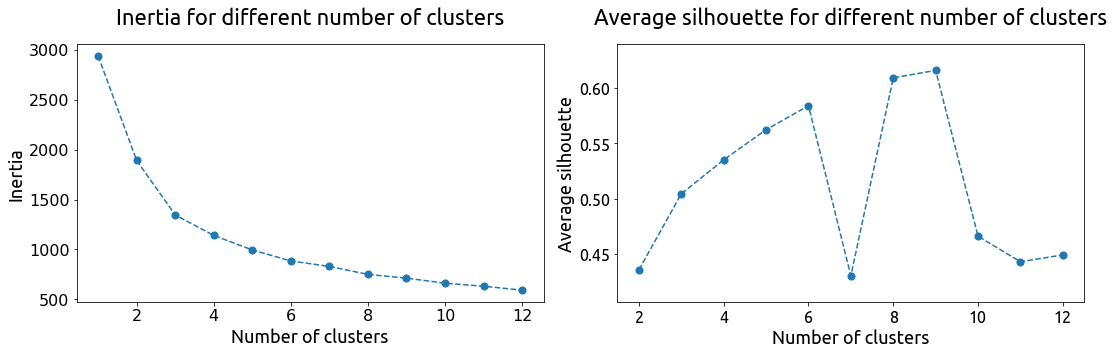

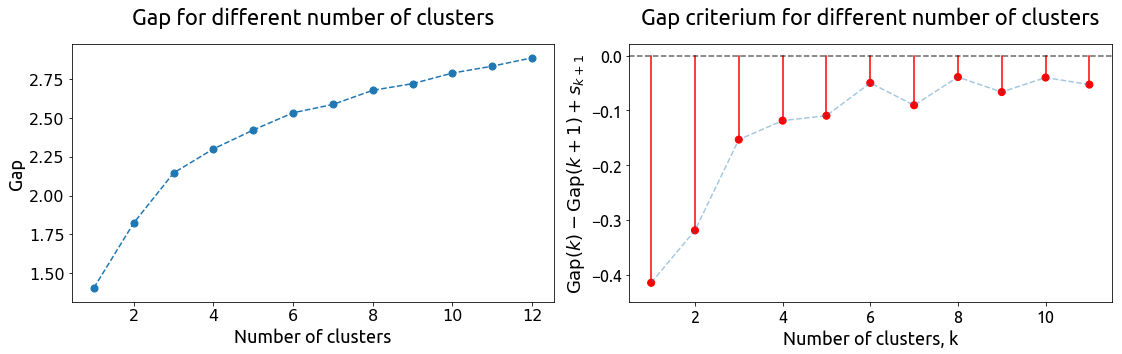

In [36]:
fig, ax = plt.subplots(ncols=2,figsize=(16,5))


ax[0].scatter(Ks,inertias, s = 50)
ax[0].plot(Ks,inertias, linestyle='--')
ax[0].set_ylabel('Inertia', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Inertia for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

ax[1].scatter(list(set(Ks)-set([1])),silhouettes, s = 50)
ax[1].plot(list(set(Ks)-set([1])),silhouettes, linestyle='--')
ax[1].set_ylabel('Average silhouette', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Average silhouette for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("NO_PCA_parfigs_1.pdf", bbox_inches='tight')
fig.tight_layout()


fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].scatter(Ks,gaps, s = 50)
ax[0].plot(Ks,gaps, linestyle='--')
ax[0].set_ylabel('Gap', fontsize=18, fontname='Ubuntu')
ax[0].set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax[0].set_title("Gap for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[0].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')


col_scatt = lambda y : 'red' if y < 0 else 'green'
cols = [ col_scatt(i) for i in gap_criterium ]

ax[1].scatter(Ks[:-1],gap_criterium, c = cols, s = 50)
ax[1].plot(Ks[:-1],gap_criterium, linestyle='--', alpha=0.4)
markerline, stemlines, baseline = ax[1].stem(Ks[:-1],gap_criterium, markerfmt=' ')
plt.setp(baseline, linewidth=0)
for i,j in enumerate(stemlines):
    plt.setp(j, c = cols[i], linestyle='-')
    
ax[1].axhline(0, linestyle='--', color='black', alpha = 0.6)
ax[1].set_ylabel('$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$', fontsize=18, fontname='Ubuntu')
ax[1].set_xlabel('Number of clusters, k', fontsize=18, fontname='Ubuntu')
ax[1].set_title("Gap criterium for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax[1].tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

#fig.savefig("NO_PCA_parfigs_2.pdf", bbox_inches='tight')
fig.tight_layout()

While the gap behavior is again not ideal, the choices $k=6,8,9$ seem promising by looking at the inertias and the silhouettes. We pick $k=8$ and plot silhouettes for all these values:

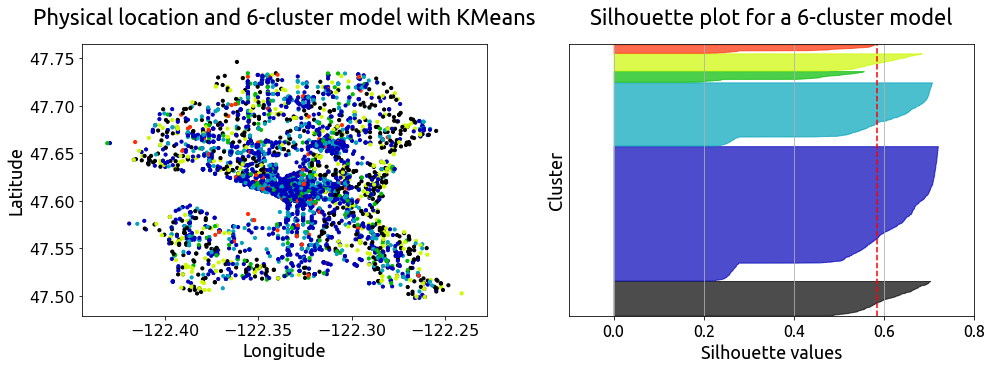

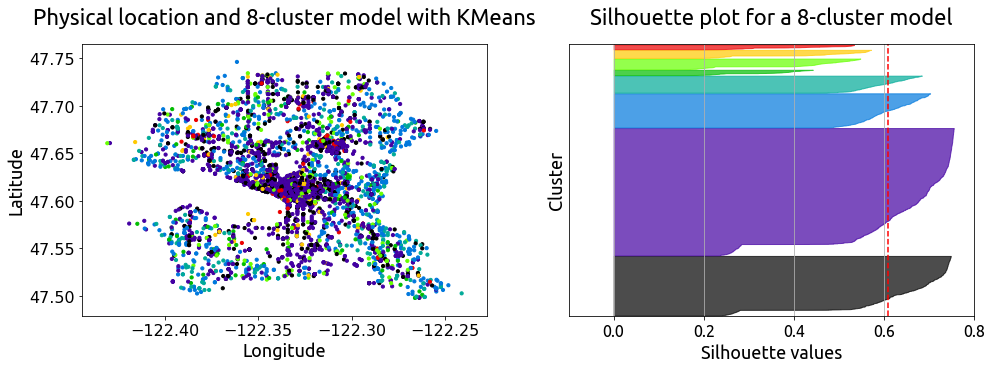

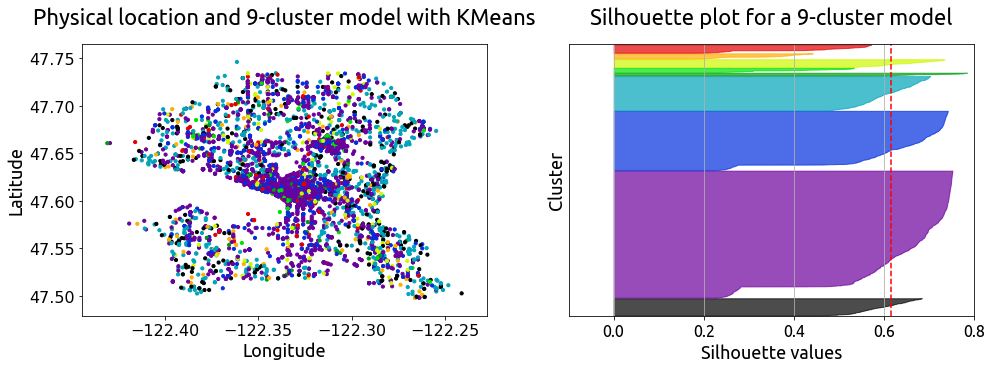

In [37]:
chosen_k = 8

for k in [6,8,9]:

    fig, ax = plt.subplots(ncols=2,figsize=(16,5))
    
    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    model = KMeans(n_clusters=k, random_state=10)
    model_labels = model.fit_predict(X)
    
    if k == chosen_k:
        chosen_k_labels = model_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, model_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, model_labels)
    
    # Labeling the clusters
    centers0 = model.cluster_centers_
    
    ################################
    
    colors = cm.nipy_spectral(model_labels.astype(float) / k)
    
    #centers = pca.transform(scaler.inverse_transform(centers0))
      

    #ax[0].scatter(pca_transformed[:,0],pca_transformed[:,1],c=colors,alpha=1, s=10)
    #ax[0].set_title("2D PCA and "+str(k)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
    #ax[0].set_xlabel("x PCA component", fontsize=18, fontname='Ubuntu')
    #ax[0].set_ylabel("y PCA component", fontsize=18, fontname='Ubuntu')
    
    centers = scaler.inverse_transform(centers0)
    
    ax[0].scatter(df['Longitude'],df['Latitude'],c=colors,alpha=1, s=10)
    ax[0].set_title("Physical location and "+str(k)+"-cluster model with KMeans", fontsize=22, fontname='Ubuntu', pad= 20)
    ax[0].set_xlabel("Longitude", fontsize=18, fontname='Ubuntu')
    ax[0].set_ylabel("Latitude", fontsize=18, fontname='Ubuntu')

    
    
    # Draw white circles at cluster centers (ORDER IN x-y REVERSED because Lat comes before Long alphabetically)
    #ax[0].scatter(centers[:, 1], centers[:, 0], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #(ORDER IN x-y REVERSED because Lat comes before Long alphabetically):
        #ax[0].scatter(c[1], c[0], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax[0].tick_params(labelsize=16)
    ax[0].grid(False)
    plt.xticks(fontname='Ubuntu')
    plt.yticks(fontname='Ubuntu')
    
    
    #########################################
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within
    ax[1].set_xlim([-0.1, 0.8])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax[1].set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax[1].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
    #    ax[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=18, fontname='Ubuntu')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[1].set_title("Silhouette plot for a "+str(k)+"-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
    ax[1].set_xlabel("Silhouette values", fontsize=18, fontname='Ubuntu')
    ax[1].set_ylabel("Cluster", fontsize=18, fontname='Ubuntu')

    # The vertical line for average silhouette score of all the values
    ax[1].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[1].set_yticks([])  # Clear the yaxis labels / tick
    #ax.set_xticks(list(np.linspace(-0.25, 0.65, num=7)))
    ax[1].xaxis.grid(True)
    ax[1].tick_params(labelsize=16)
    plt.xticks(fontname='Ubuntu')
    
    #fig.savefig("NO_PCA_clusfigs_"+str(k)+"_cluster.pdf", bbox_inches='tight')

We save the labels as before:

In [35]:
#np.save('complete_data_chosen_k_labels.npy', chosen_k_labels)